In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [60]:
data = pd.read_csv('car_data.csv')

cols = ['Make','Model','Year','Engine HP','Engine Cylinders','Transmission Type','Vehicle Style','highway MPG','city mpg','MSRP']
data = data[cols]

data.columns = data.columns.str.replace(' ', '_').str.lower()

data = data.fillna(0).rename(columns={'msrp':'price'})

# Question 1

In [61]:
data.transmission_type.value_counts(normalize=True).round(2)

AUTOMATIC           0.69
MANUAL              0.25
AUTOMATED_MANUAL    0.05
DIRECT_DRIVE        0.01
UNKNOWN             0.00
Name: transmission_type, dtype: float64

# Question 2

In [62]:
data.corr(method='pearson').round(2)

,year,engine_hp,engine_cylinders,highway_mpg,city_mpg,price
year,1.00,0.34,-0.04,0.26,0.20,0.23
engine_hp,0.34,1.00,0.77,-0.42,-0.42,0.65
engine_cylinders,-0.04,0.77,1.00,-0.61,-0.59,0.53
highway_mpg,0.26,-0.42,-0.61,1.00,0.89,-0.16
city_mpg,0.20,-0.42,-0.59,0.89,1.00,-0.16
price,0.23,0.65,0.53,-0.16,-0.16,1.00


Text(0.5, 1.0, 'Correlation within numerical variables')

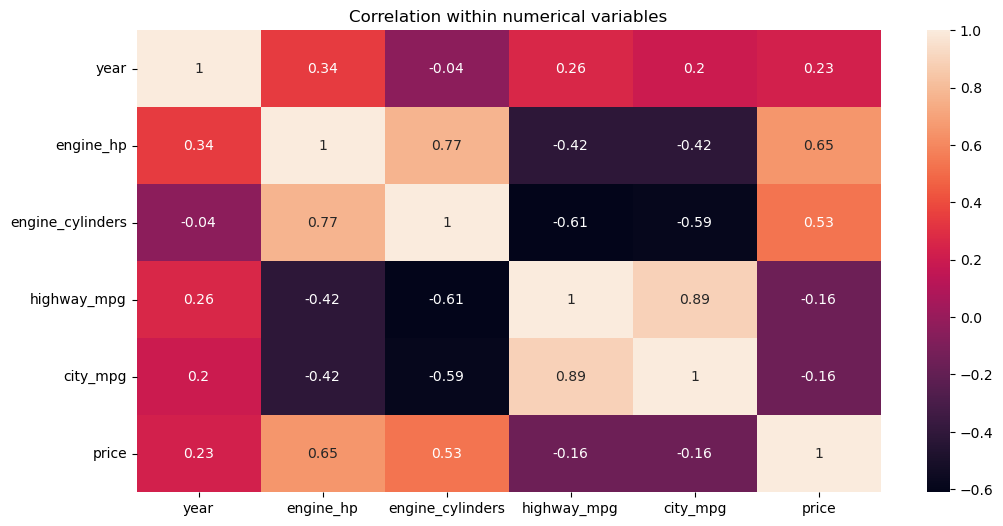

In [63]:
plt.figure(figsize=(12, 6))
sns.heatmap(data.corr(method='pearson').round(2), annot = True)
plt.title('Correlation within numerical variables')

In [64]:
data['above_average'] = np.where(data.price > data.price.mean(), 1, 0)

In [65]:
df_train_full, df_test = train_test_split(data.drop(columns=['price']), test_size=0.2, random_state=42)

df_train, df_val = train_test_split(df_train_full, test_size=(.2/.8), random_state=42)

In [66]:
y_train = df_train.above_average.values
y_val = df_val.above_average.values

del df_train['above_average']
del df_val['above_average']

#E test??

# Question 3

In [67]:
def calculate_mi(series):
    return mutual_info_score(series, df_train_full.above_average)

df_mi = df_train_full.select_dtypes('object').apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')

df_mi

,MI
model,0.460994
make,0.238724
vehicle_style,0.083390
transmission_type,0.020884


# Question 4

In [68]:
dv = DictVectorizer(sparse=False)

train_full_dict = df_train_full.to_dict(orient='records')
dv.fit(train_full_dict)

train_dict = df_train.to_dict(orient='records')
X_train = dv.transform(train_dict)
#dv.get_feature_names_out()

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [69]:
model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=1000, random_state=42, solver='liblinear')

In [70]:
y_pred = model.predict_proba(X_val)[:, 1]

above_avg = y_pred > 0.5

accuracy_q4 = (y_val == above_avg).mean()

print(accuracy_q4.round(2))

0.95


# Question 5

In [71]:
features = df_train.columns.tolist()

accuracies = []

for i in features:
    train_full_dict = df_train_full.drop(columns=[i]).to_dict(orient='records')
    dv.fit(train_full_dict)

    train_dict = df_train.drop(columns=[i]).to_dict(orient='records')
    X_train = dv.transform(train_dict)

    val_dict = df_val.drop(columns=[i]).to_dict(orient='records')
    X_val = dv.transform(val_dict)


    model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)[:, 1]
    above_avg = y_pred > 0.5
    accuracy = (y_val == above_avg).mean()

    accuracies.append(f'Accuracy without {i} is {round(accuracy,4)}, with a {abs(round(accuracy_q4-accuracy,4))} difference')


In [72]:
accuracies

['Accuracy without make is 0.948, with a 0.0029 difference',
 'Accuracy without model is 0.9161, with a 0.029 difference',
 'Accuracy without year is 0.948, with a 0.0029 difference',
 'Accuracy without engine_hp is 0.924, with a 0.021 difference',
 'Accuracy without engine_cylinders is 0.9471, with a 0.0021 difference',
 'Accuracy without transmission_type is 0.945, with a 0.0 difference',
 'Accuracy without vehicle_style is 0.9408, with a 0.0042 difference',
 'Accuracy without highway_mpg is 0.9475, with a 0.0025 difference',
 'Accuracy without city_mpg is 0.9459, with a 0.0008 difference']

# Question 6

In [78]:
df_train_full, df_test = train_test_split(data.drop(columns=['above_average']), test_size=0.2, random_state=42)

df_train, df_val = train_test_split(df_train_full, test_size=(.2/.8), random_state=42)

df_train['log_price'] = np.log1p(df_train['price'])
df_val['log_price'] = np.log1p(df_val['price'])

y_train = df_train.log_price.values
y_val = df_val.log_price.values

df_train = df_train.drop(columns=['price','log_price'])
df_val = df_val.drop(columns=['price','log_price'])

dv = DictVectorizer(sparse=False)

train_full_dict = df_train_full.to_dict(orient='records')
dv.fit(train_full_dict)

train_dict = df_train.to_dict(orient='records')
X_train = dv.transform(train_dict)
#dv.get_feature_names_out()

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [79]:
alphas = [0, 0.01, 0.1, 1, 10]

rmse_scores = {}

for alpha in alphas:
    model = Ridge(alpha=alpha, solver='sag', random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    
    print(f'{alpha}: {rmse.round(3)}')